**Questions to ask**

1. What states are providing the highest paying jobs where the business owner is female?
2. Is there a significant difference between the number of employees under male and female business owners?

**Extraction**

API request gets the name of the state (NAME), the sex code (SEX) and sex label (SEX_LABEL) of business owner, number of employees (EMP) working for business owner of that sex breakdown, the total annual payroll (PAYANN) for the business owners of that sex breakdown, and the state fips code (state). The data is then transformed to a json object and into a pandas dataframe where the first row is the column header.

In [25]:
import requests

link = 'https://api.census.gov/data/2018/abscs?get=NAME,SEX,SEX_LABEL,EMP,PAYANN&for=state:*&key='
key = [YOUR KEY]
response = requests.get(link+key)

import pandas as pd
import json
response_list = response.json()
df = pd.DataFrame(response_list[1:], columns = response_list[0])

**Transformation**

Need to manipulate data in a way to run calculations to control for larger states dominating the PAYANN and EMP data by creating a new column that divides the annual payroll by the number of employees. But first need to convert data into integers in order to run calculations. Since the PAYANN column is so large, the numpy package must be loaded. 

In [26]:
import numpy as np
df['EMP'] = df['EMP'].astype(str).astype(int) # convert employee data to int
df['PAYANN'] = df['PAYANN'].astype(str).astype(np.int64) # convert annual payroll to int64 with numpy
df.info() # verify that EMP and PAYANN were converted to int and int64 respectively

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204 entries, 0 to 203
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   NAME       204 non-null    object
 1   SEX        204 non-null    object
 2   SEX_LABEL  204 non-null    object
 3   EMP        204 non-null    int32 
 4   PAYANN     204 non-null    int64 
 5   state      204 non-null    object
dtypes: int32(1), int64(1), object(4)
memory usage: 8.9+ KB


To get data in a format to make plotting easier, want to create a table with a separate column for pay/employee based on male and female business owners. This newly arranged data will be used for bargraphs in the report.

In [27]:
df['pay/emp'] = df.apply(lambda x: 0 if x['EMP'] < 1 else (x['PAYANN']/x['EMP'])*1000, axis=1) # get annual pay per employee, 
#the PAYANN value is in terms of 1,000 so multiply by 1,000

female = df[df.SEX_LABEL == 'Female'] # create dataframe where SEX_LABEL = 'Female'
male = df[df.SEX_LABEL == 'Male'] # create dataframe where SEX_LABEL = 'Male'

male2 = male[['NAME', 'pay/emp']] # create dataframe of just state name and pay/emp
male2 = male2.rename(columns = {'pay/emp': 'pay/emp_male'}) # rename 'pay/emp' to 'pay/emp_male'

female2 = female[['NAME', 'pay/emp']] # create dataframe of just state name and pay/emp
female2 = female2.rename(columns = {'pay/emp': 'pay/emp_female'}) #rename 'pay/emp' to 'pay/emp_female'

together = female2.merge(male2, how = 'inner', on = 'NAME') # merge the two newly created datasets together
together_sort = together.sort_values(by = 'pay/emp_female', ascending = False) # sort by female pay/employee
together_sort[:10] # view top 10 in dataframe based on sort

,NAME,pay/emp_female,pay/emp_male
27,District of Columbia,57030.621328,73050.761136
47,Alaska,50417.217935,56739.589091
26,Delaware,50260.590692,48356.545634
7,New York,44576.151506,54839.725038
18,Virginia,43027.202166,51076.990030
6,New Jersey,42995.081846,47260.387339
39,Massachusetts,42836.071347,56712.909485
19,Washington,42716.311171,52881.563232
48,California,42651.510817,54353.740470
38,Maryland,42358.207693,52526.689309


In order to find which, if any states, have female business owners paying more per employee than male business owners need to create a new value called 'ratio' that is the ratio of 'pay/emp_female' over 'pay/emp_male'. For values greater than 1, the female business owners are paying more per employee than the male business owners in the state.

In [28]:
together['ratio'] = together['pay/emp_female']/together['pay/emp_male'] # find the ratio between male and female pay/employee
together_sort2 = together.sort_values(by = 'ratio', ascending = False) # sort by ratio value
together_sort2_nola = together_sort2[together_sort2.NAME != 'Louisiana'] # remove Louisiana from dataframe as there is no 
#data for male business owners and the resulting ratio is INF
together_sort2_nola[:3] # top 3 in ratio sort

,NAME,pay/emp_female,pay/emp_male,ratio
26,Delaware,50260.590692,48356.545634,1.039375
31,Idaho,30051.802134,30156.048824,0.996543
4,Nevada,37575.331065,38954.970105,0.964584


In [29]:
together_sort2_nola[-3:] # last three in ratio sort

,NAME,pay/emp_female,pay/emp_male,ratio
28,Connecticut,34926.882683,58551.589302,0.596515
44,Rhode Island,0.000000,47053.386955,0.000000
9,North Dakota,0.000000,52484.235276,0.000000


Below a dataframe is created that removes the 'Total' and 'Equally male/female' from the dataframe, leaving only male and female values to be used for plotting.

In [30]:
df_nototal = df[df.SEX_LABEL != 'Total'] # remove Total from dataframe
df_noeq = df_nototal[df_nototal.SEX_LABEL !='Equally male/female'] # remove 'Equally male/female' from dataframe for ease in viewing
sorted_totals_comb = df_noeq.sort_values(by='pay/emp', ascending = False) # sort dataframe by 'pay/emp'
sorted_totals_comb = sorted_totals_comb[:-3] # drop bottom 3 rows with 0 data

**Plotting Code and Visuals**

In [31]:
import plotly.express as px

plot_comb = sorted_totals_comb

fig = px.scatter(x = plot_comb.EMP.astype(float) , y= plot_comb['pay/emp'].astype(float), color = plot_comb.SEX_LABEL,
                labels = {'x' : 'Number of Employees',
                       'y' : 'Average Payroll per Employee',
                         'color': 'Business-ownership sex breakdown'},
                 template = 'plotly_white',
                title = 'Business\' Average Payroll per Employee vs Number of Employees')
fig.show()

In [32]:
import plotly.graph_objects as go

sorted_totals_top10 = together_sort[:10] # take top 10 states from sort by female business owners' pay/emp

fig = go.Figure(data=[
    go.Bar(name='Female Business Owners', x=sorted_totals_top10['NAME'], y=sorted_totals_top10['pay/emp_female']),
    go.Bar(name='Male Business Owners', x=sorted_totals_top10['NAME'], y=sorted_totals_top10['pay/emp_male'])
])

fig.update_layout(title = 'Average Annual Pay per Employee',
                  xaxis_title = 'State',
                  yaxis_title = 'Average Annual Pay',
                  legend_title = 'Sex of Business Owner',
                  barmode='group')

fig.show()

In [33]:
together_sort2_top10 = together_sort2_nola[:10]

fig = go.Figure(data=[
    go.Bar(name='Female Average Pay', x=together_sort2_top10['NAME'], y=together_sort2_top10['pay/emp_female']),
    go.Bar(name = 'Male Average Pay', x = together_sort2_top10['NAME'], y=together_sort2_top10['pay/emp_male'])
])
# Change the bar mode
fig.update_layout(title = 'Average Annual Pay Based on Sex of Business Owner, sorted by Ratio',
                 xaxis_title = 'State',
                 yaxis_title = 'Average Annual Pay',
                 legend_title = 'Sex of Business Owner',
                 barmode = 'group')
fig.show()

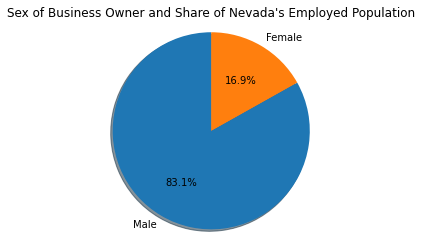

In [34]:
import matplotlib.pyplot as plt 
%matplotlib inline

nv = df[df.state == '32'] # create dataframe of only NV
nv_pie = nv[nv.SEX_LABEL != 'Total'] # drop total from dataframe
nv_pie = nv_pie[nv_pie.SEX_LABEL != 'Equally male/female']
nv_pie = nv_pie.sort_values(by = 'SEX_LABEL', ascending = False)
fig1, ax1 = plt.subplots()

ax1.pie(nv_pie.EMP, labels=nv_pie.SEX_LABEL, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Sex of Business Owner and Share of Nevada\'s Employed Population')
plt.show()

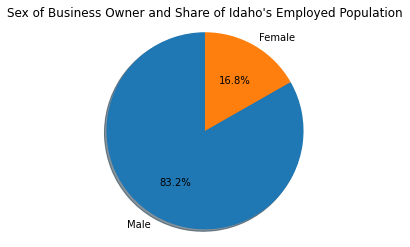

In [35]:
idaho = df[df.state == '16'] # create dataframe of only ID
idaho_pie = idaho[idaho.SEX_LABEL != 'Total'] # drop total from dataframe
idaho_pie = idaho_pie[idaho_pie.SEX_LABEL != 'Equally male/female']
idaho_pie = idaho_pie.sort_values(by = 'SEX_LABEL', ascending = False)
fig1, ax1 = plt.subplots()

ax1.pie(idaho_pie.EMP, labels=idaho_pie.SEX_LABEL, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Sex of Business Owner and Share of Idaho\'s Employed Population')
plt.show()

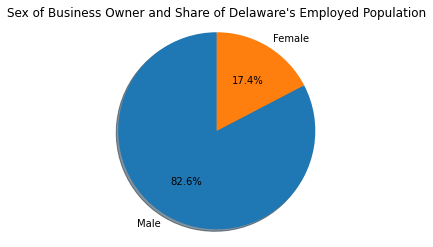

In [36]:
de = df[df.state == '10'] # create dataframe of only TN
de_pie = de[de.SEX_LABEL != 'Total'] # drop total from dataframe
de_pie = de_pie[de_pie.SEX_LABEL != 'Equally male/female'] # drop equally male/female for report
de_pie = de_pie.sort_values(by = 'SEX_LABEL', ascending = False)
fig1, ax1 = plt.subplots()

ax1.pie(de_pie.EMP, labels=de_pie.SEX_LABEL, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Sex of Business Owner and Share of Delaware\'s Employed Population')
plt.show()

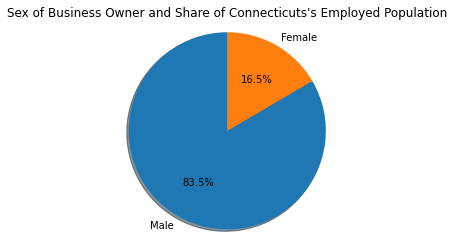

In [37]:
ct = df[df.state == '09'] # create dataframe of only TN
ct_pie = ct[ct.SEX_LABEL != 'Total'] # drop total from dataframe
ct_pie = ct_pie[ct_pie.SEX_LABEL != 'Equally male/female'] # drop equally male/female for report
ct_pie = ct_pie.sort_values(by = 'SEX_LABEL', ascending = False)
fig1, ax1 = plt.subplots()

ax1.pie(ct_pie.EMP, labels=ct_pie.SEX_LABEL, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Sex of Business Owner and Share of Connecticuts\'s Employed Population')
plt.show()